# SNEMI3D Dataset Exploration

This notebook provides exploratory data analysis (EDA) of the SNEMI3D dataset
for connectomics neuron segmentation.

## Contents
1. Load and inspect volume data (AC3 and AC4)
2. Visualize EM slices and labels
3. Label distribution analysis
4. Resolution and anisotropy

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

from neurons.utils.io import find_folder, load_volume

# ---------- Matplotlib defaults: LaTeX font, tab20, aspect=equal ----------
matplotlib.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'DejaVu Serif'],
    'mathtext.fontset': 'cm',
    'font.size': 12,
    'axes.titlesize': 13,
    'axes.labelsize': 12,
})

CMAP_LABELS = plt.cm.tab20

%matplotlib inline

## 1. Load Volume Data

SNEMI3D provides two volumes:
- **AC4** -- Training volume (100 slices, 1024 x 1024) with labels
- **AC3** -- Test volume (100 slices, 1024 x 1024), labels may or may not be available

Resolution: 6 x 6 x 30 nm (anisotropic).

Set `DATA_ROOT` to the directory containing your SNEMI3D files.

In [2]:
DATA_ROOT = Path('../data/snemi3d')

SAMPLES = {
    'AC3': {'inputs': 'AC3_inputs', 'labels': 'AC3_labels'},
    'AC4': {'inputs': 'AC4_inputs', 'labels': 'AC4_labels'},
}

volumes = {}
labels = {}

for name, files in SAMPLES.items():
    vol_path = find_folder(DATA_ROOT, files['inputs'])
    seg_path = find_folder(DATA_ROOT, files['labels'])

    print(f'--- {name} ---')
    print(f'  Volume path: {vol_path}')
    print(f'  Labels path: {seg_path}')

    if vol_path is not None:
        v = load_volume(vol_path)
        volumes[name] = v
        print(f'  Volume shape: {v.shape}  dtype={v.dtype}  range=[{v.min()}, {v.max()}]')
    else:
        print(f'  Volume not found.')

    if seg_path is not None:
        s = load_volume(seg_path)
        labels[name] = s
        print(f'  Labels shape: {s.shape}  dtype={s.dtype}  unique={len(np.unique(s))}')
    else:
        print(f'  Labels not found.')

    print()

--- AC3 ---
  Volume path: ../data/snemi3d/AC3_inputs.h5
  Labels path: ../data/snemi3d/AC3_labels.h5
  Volume shape: (100, 1024, 1024)  dtype=uint8  range=[0, 255]
  Labels shape: (100, 1024, 1024)  dtype=uint16  unique=334

--- AC4 ---
  Volume path: ../data/snemi3d/AC4_inputs.h5
  Labels path: ../data/snemi3d/AC4_labels.h5
  Volume shape: (100, 1024, 1024)  dtype=uint8  range=[0, 255]
  Labels shape: (100, 1024, 1024)  dtype=uint16  unique=401



## 2. Visualize EM Slices and Labels

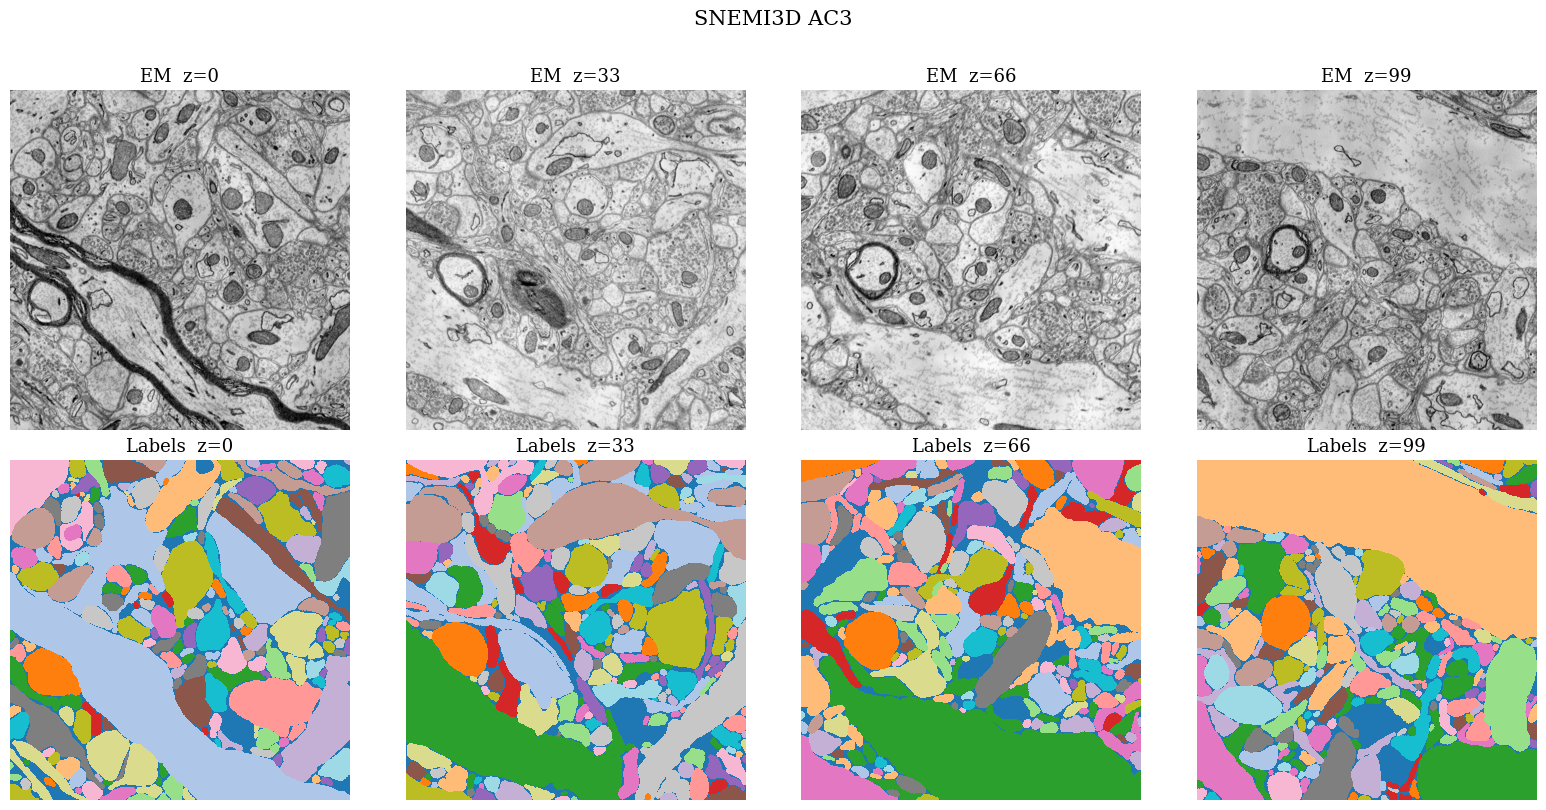

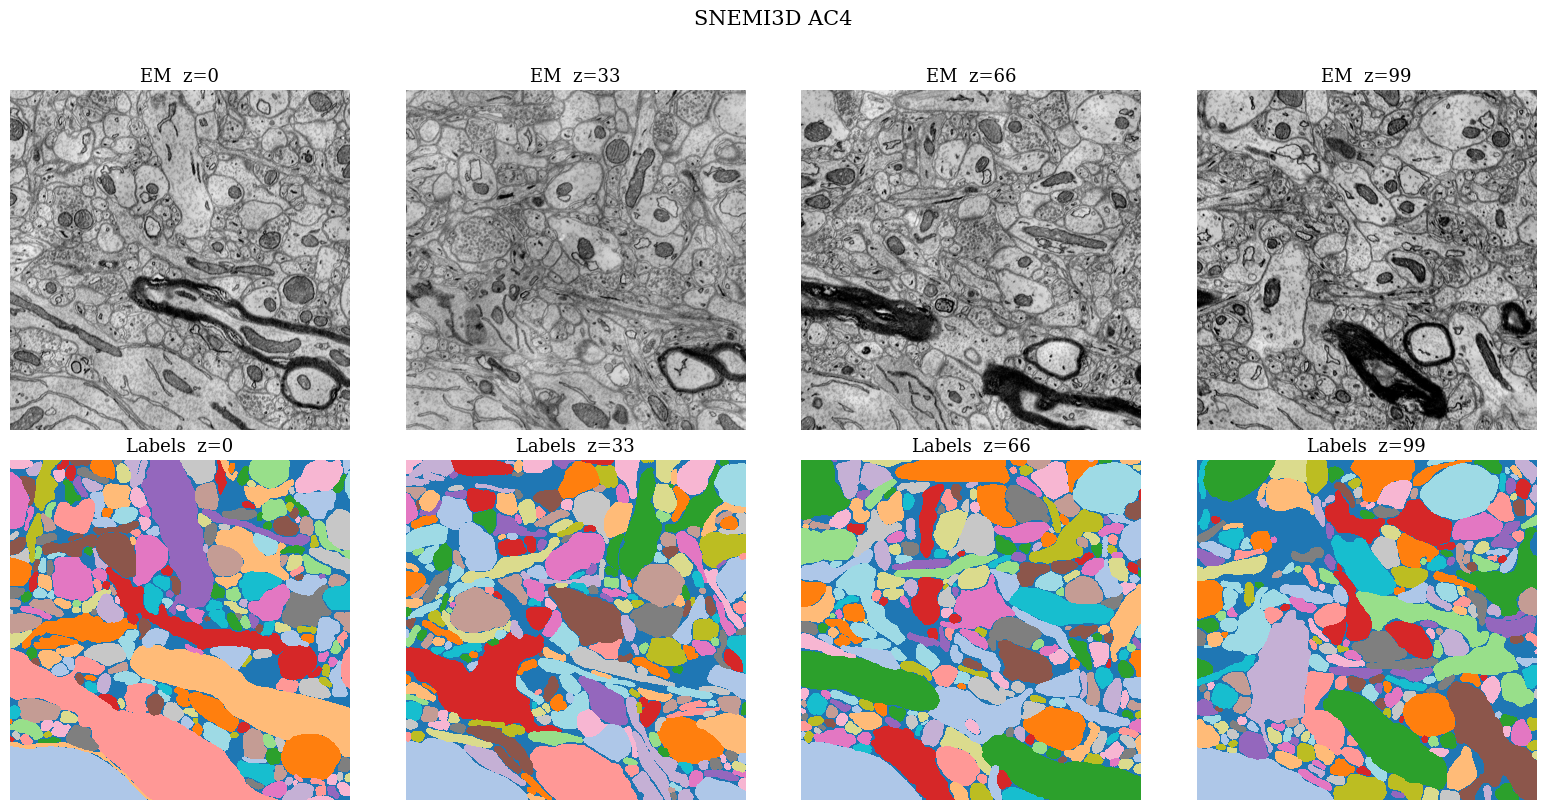

In [3]:
for name in SAMPLES:
    if name not in volumes:
        continue

    vol = volumes[name]
    has_labels = name in labels
    n_rows = 2 if has_labels else 1

    slice_indices = np.linspace(0, vol.shape[0] - 1, 4, dtype=int)

    fig, axes = plt.subplots(n_rows, 4, figsize=(16, 4 * n_rows))
    if n_rows == 1:
        axes = axes[np.newaxis, :]

    for i, idx in enumerate(slice_indices):
        axes[0, i].imshow(vol[idx], cmap='gray', aspect='equal')
        axes[0, i].set_title(f'EM  z={idx}')
        axes[0, i].axis('off')

        if has_labels:
            axes[1, i].imshow(labels[name][idx] % 20, cmap=CMAP_LABELS, interpolation='nearest', aspect='equal')
            axes[1, i].set_title(f'Labels  z={idx}')
            axes[1, i].axis('off')

    fig.suptitle(f'SNEMI3D {name}', fontsize=15, y=1.01)
    fig.tight_layout()
    plt.show()

## 3. Label Distribution

--- AC3 ---
  Background voxels :    7,925,285 (7.6%)
  Foreground voxels :   96,932,315 (92.4%)
  Neuron instances  : 333


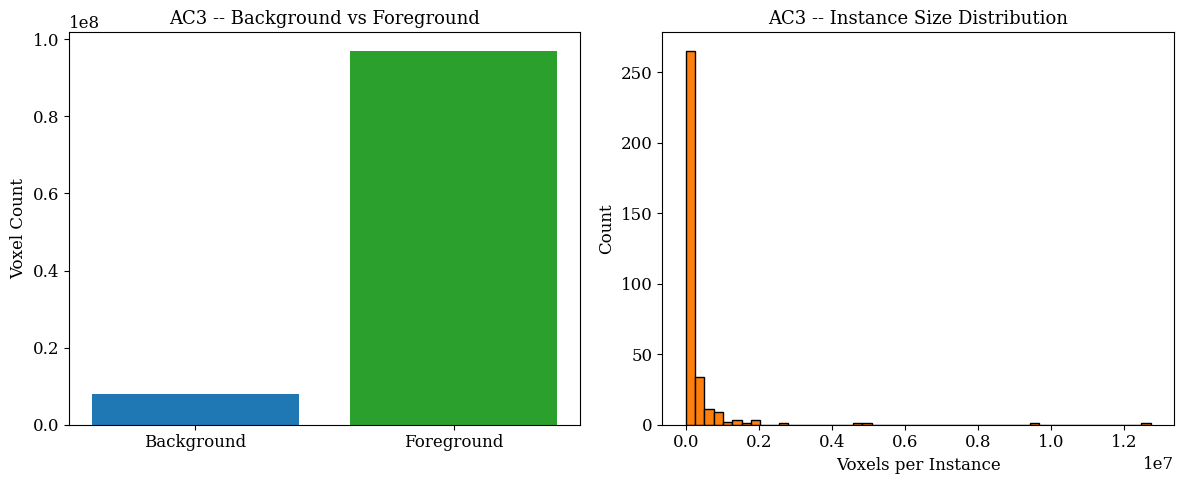


--- AC4 ---
  Background voxels :   10,713,442 (10.2%)
  Foreground voxels :   94,144,158 (89.8%)
  Neuron instances  : 400


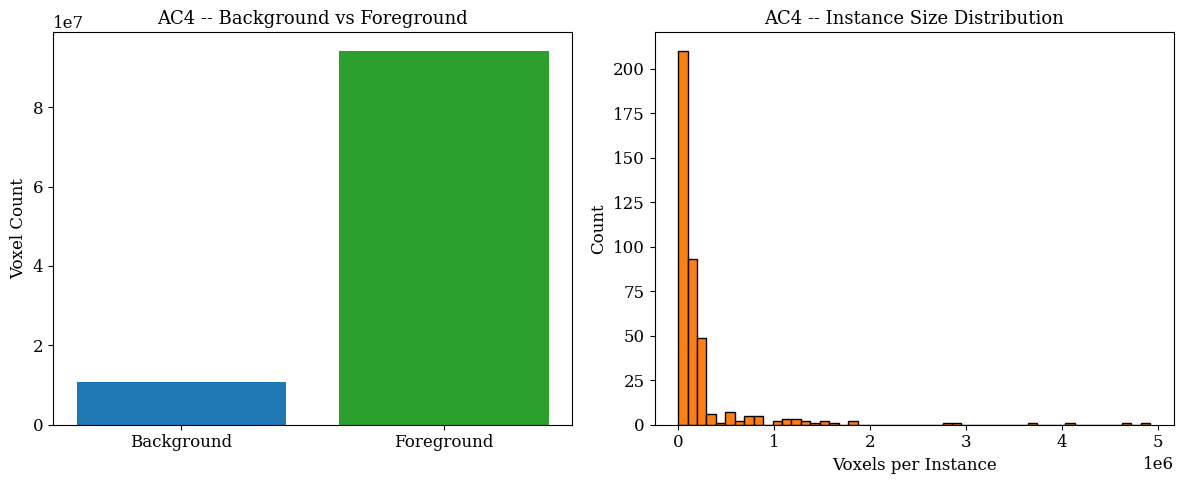

In [4]:
for name in SAMPLES:
    if name not in labels:
        continue

    lbl = labels[name]
    unique_ids, counts = np.unique(lbl, return_counts=True)

    bg_count = int(counts[unique_ids == 0].sum()) if 0 in unique_ids else 0
    fg_count = int(counts[unique_ids > 0].sum())
    n_instances = len(unique_ids[unique_ids > 0])

    print(f'--- {name} ---')
    print(f'  Background voxels : {bg_count:>12,} ({100 * bg_count / lbl.size:.1f}%)')
    print(f'  Foreground voxels : {fg_count:>12,} ({100 * fg_count / lbl.size:.1f}%)')
    print(f'  Neuron instances  : {n_instances}')

    fg_counts = counts[unique_ids > 0]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    colors_bar = [CMAP_LABELS(0), CMAP_LABELS(4)]
    axes[0].bar(['Background', 'Foreground'], [bg_count, fg_count], color=colors_bar)
    axes[0].set_title(f'{name} -- Background vs Foreground')
    axes[0].set_ylabel('Voxel Count')
    axes[0].set_aspect('auto')

    axes[1].hist(fg_counts, bins=50, edgecolor='black', color=CMAP_LABELS(2))
    axes[1].set_title(f'{name} -- Instance Size Distribution')
    axes[1].set_xlabel('Voxels per Instance')
    axes[1].set_ylabel('Count')
    axes[1].set_aspect('auto')

    fig.tight_layout()
    plt.show()
    print()

## 4. Resolution and Anisotropy

SNEMI3D has anisotropic resolution: 6 x 6 x 30 nm (XY vs Z).

In [5]:
resolution = {'x': 6.0, 'y': 6.0, 'z': 30.0}  # nanometers
anisotropy = resolution['z'] / resolution['x']

print(f'Resolution: {resolution}')
print(f'Anisotropy factor (Z/XY): {anisotropy:.1f}x')
print(f'\nImplication: Z-axis has {anisotropy:.0f}x lower resolution.')
print('Consider using anisotropic augmentations and patch sizes.')

Resolution: {'x': 6.0, 'y': 6.0, 'z': 30.0}
Anisotropy factor (Z/XY): 5.0x

Implication: Z-axis has 5x lower resolution.
Consider using anisotropic augmentations and patch sizes.
